<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter5/Chapter5_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jpub-dongdong9/TimeSeriesForecastingInPython/refs/heads/master/data/foot_traffic.csv")
df

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695
...,...
995,706.009031
996,705.610549
997,704.771335
998,703.559920


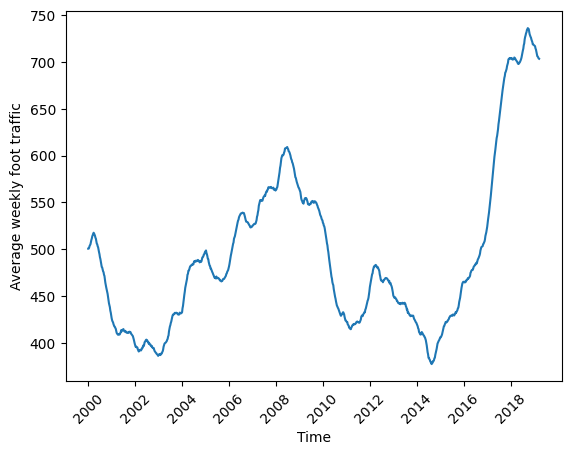

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots()

plt.plot(df)

plt.xlabel('Time')
plt.ylabel('Average weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
plt.xticks(rotation = 45)
# fig.autofmt_xdate()
plt.show()

정상성을 가지고 있지 않고, 계절성도 딱히 있어 보이지 않다.  
ADF테스트를 수행해 확인해보자

In [9]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df)
print(ADF_result)

(-1.1758885999240747, 0.683880891789619, 3, 996, {'1%': -3.4369325637409154, '5%': -2.8644462162311934, '10%': -2.568317409920808}, 2740.300875453594)


p-value가 0.05보다 크므로, 귀무가설이 채택되고, 따라서 수열은 비정상적이다.  
따라서 차분을 적용하여 정상적으로 만들어주겠다.  

In [16]:
foot_traffic_diff = np.diff(df['foot_traffic'],n=1)
foot_traffic_diff.shape

(999,)

1차분을 진행하여 데이터의 길이가 1 줄어든것을 볼 수 있다.

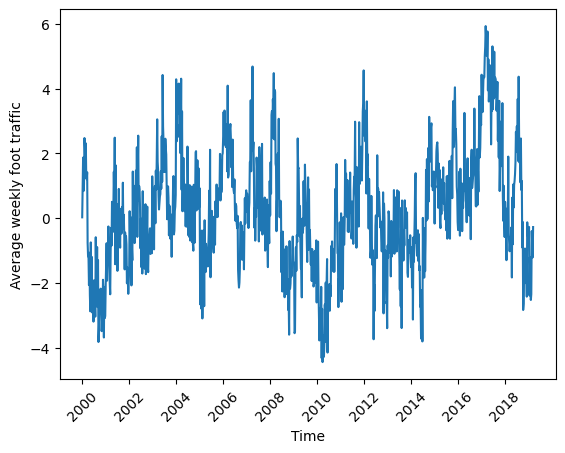

In [17]:

fig,ax = plt.subplots()

plt.plot(foot_traffic_diff)

plt.xlabel('Time')
plt.ylabel('Average weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
plt.xticks(rotation = 45)
plt.show()

도식화하여 살펴보면 추세 효과를 잘 제거한 것으로 보인다. 다시한번 ADF테스트를 통해 확인해보자

In [18]:
ADF_result = adfuller(foot_traffic_diff)
ADF_result

(-5.268231347422044,
 6.369317654781239e-06,
 2,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 2735.535696297212)

이번에는 p-value가 0.05보다 낮아, 수열이 정상적프로세스임을 확인 할 수 있다.

다음으로 ACF를 도식화하여 자기상관관계가 있는지 확인해보자

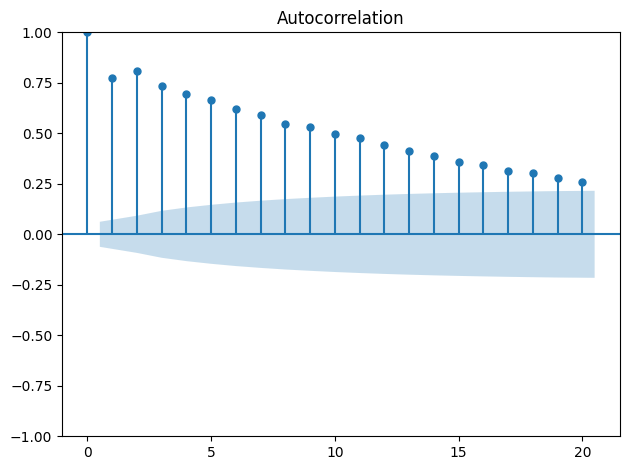

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(foot_traffic_diff, lags = 20)

plt.tight_layout()

지연 0 이후에 유의한 자기상관계수가 있음을 알 수 있다. 따라서 이 프로세스는 확률보행이 아니다.  
또한 지연이 증가함에 따라 계수가 기하급수적으로 감소함을 알 수 있다. 따라서 계수가 갑자기 유의하지 않게 되는 어떤 지연값이 존재하지 않고, 이는 이동평균과정이 없고 자귀화귀과정이 내재되어 있을 가능성이 높음을 의미한다.  


그럼 이제 AR(p) 프로세스의 차수 p를 식별할 수 있는 편자기상관함수 도식을 살펴보자

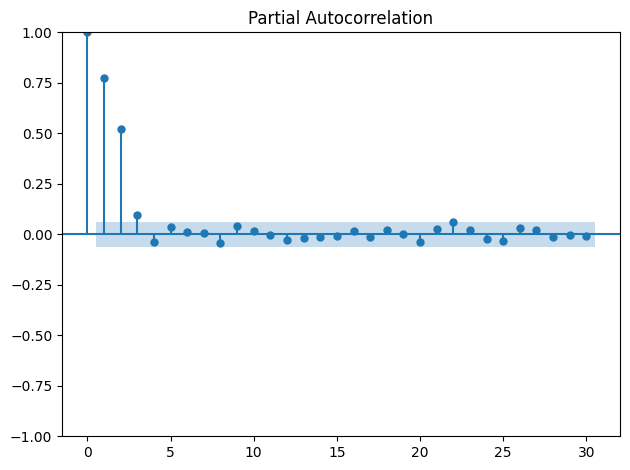

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(foot_traffic_diff)
plt.tight_layout()

PACF도식에서 지연 3 이후에는 편자기상관계수가 0에서 큰 차이가 없음을 분명히 할 수 있다. 따라서 주어진 데이터는 차수 3인 자귀회귀과정이고, AR(3)으로 표현할 수 있다.


# 자기회귀과정 예측하기

데이터 집합을 사용하여 다음 주 소매점의 평균 유동인구를 예측해보자.  
예측 결과를 평가하기 위해 지난 52주간의 데이터는 테스트 집합에 저장하고, 나머지는 훈련 집합에 저장한다.

In [30]:
df_diff = pd.DataFrame({'foot_traffic_diff' : foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


원본 수열과 차분된 수열을 모두 시각화해보자

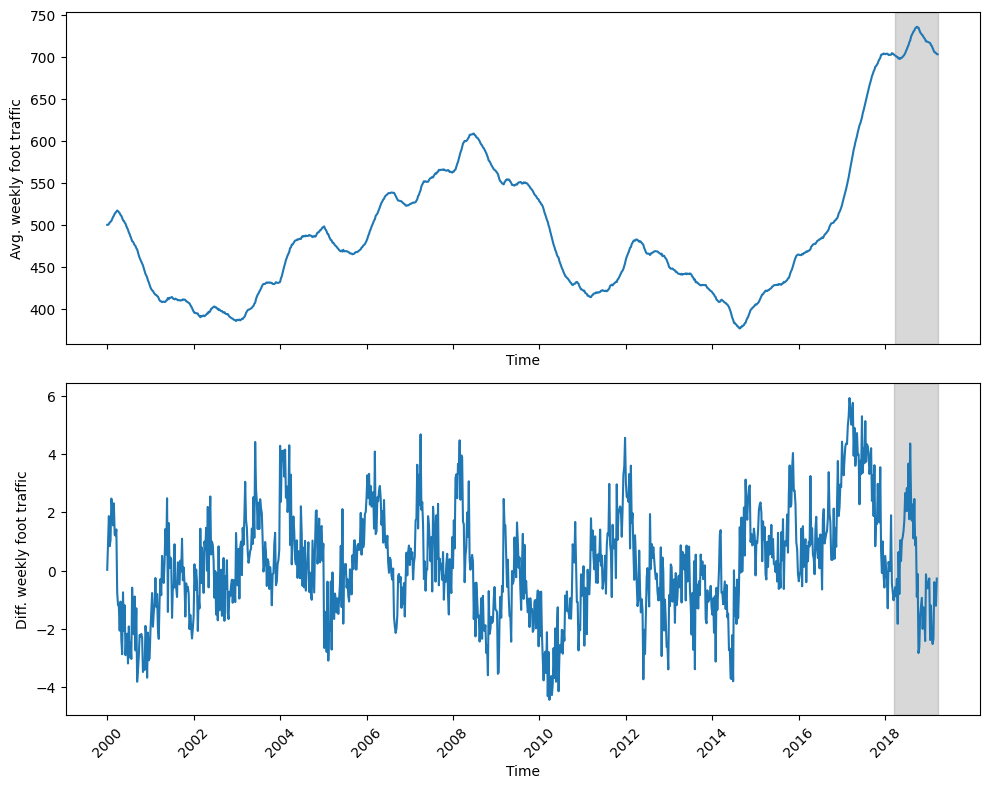

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10,8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color = "#808080", alpha = 0.3)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. weekly foot traffic')
ax2.axvspan(947, 999, color = "#808080", alpha = 0.3)

plt.xticks(np.arange(0,1000,104), np.arange(2000, 2020, 2))

plt.xticks(rotation = 45)
plt.tight_layout()

이전과 마찬가지로 롤링 예측을 수행해보자

In [53]:
df_diff[:4].iloc[-1].values[0]

0.8367051305480118

In [50]:
df_diff.iloc[:4]

,foot_traffic_diff
0,0.025651
1,0.904511
2,1.869114
3,0.836705


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df : pd.DataFrame, train_len :int, horizon : int, window : int, method : str) -> list:
  total_len = train_len + horizon
  end_idx = train_len

  if method == 'mean':
      pred_mean = []
      for i in range(train_len, total_len, window):
        mean = np.mean(df[:i].values)
        pred_mean.extend(mean for _ in range(window))
      return pred_mean
  elif method == 'last':
    pred_last = []
    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last.extend(last_value for _ in range(window))
    return pred_last
  elif method == 'AR':
    pred_AR = []
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order = (3,0,0))
      res = model.fit(disp = False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_AR.extend(oos_pred)
    return pred_AR


In [144]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test.loc[:,'pred_mean'] = pred_mean
test.loc[:,'pred_last'] = pred_last
test.loc[:,'pred_AR'] = pred_AR
test

,foot_traffic_diff,pred_mean,pred_last,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279
952,0.635514,0.207574,-1.830685,-0.810733
953,-0.807623,0.208023,0.635514,-0.713463
954,1.040389,0.206959,-0.807623,-0.144974
955,0.326728,0.207831,1.040389,0.002759
956,1.028235,0.207956,0.326728,0.520063


[]

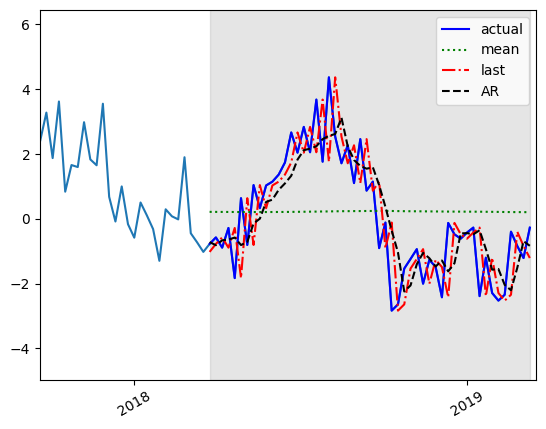

In [75]:
fig, ax = plt.subplots()

plt.plot(df_diff)
plt.plot(test.iloc[:,-4], 'b-', label ='actual')
plt.plot(test.iloc[:,-3], 'g:', label ='mean')
plt.plot(test.iloc[:,-2], 'r-.', label ='last')
plt.plot(test.iloc[:,-1], 'k--', label ='AR')
ax.set_xlim(920, 999)
ax.axvspan(947, 998, color = '#808080', alpha = 0.2)
plt.xticks([935, 988], [2018, 2019])
plt.xticks(rotation = 30)
plt.legend()
plt.plot()

어떤 기법이 가장 성능이 좋은지 MSE로 측정해보겠다

In [78]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean)
print(mse_last)
print(mse_AR)

3.1079979374701447
1.448730118495964
0.9242479164116852


AR(3)모델이 가장 적합한 기법이라는 결론을 내릴 수 있다.

## 역변환

예측값으니 1차분된 값이므로, 예측값을 원래의 데이터 규모로 되돌리기 위해 역변환을 진행해보자.

In [126]:
test_cumsum = test['pred_AR'].cumsum()
test_cumsum.index = df.loc[948:].index

df['pred_foot_traffic'] = pd.Series()
df.loc[948:,'pred_foot_traffic'] = df.loc[947,'foot_traffic'] + test_cumsum
df[947:]

,foot_traffic,pred_foot_traffic
947,702.463430,NaN
948,701.686830,701.743716
949,701.112198,700.929169
950,700.221501,700.264431
951,699.937948,699.622962
952,698.107264,699.043684
953,698.742777,698.23295
954,697.935155,697.519487
955,698.975544,697.374513
956,699.302273,697.377273


이를 기반으로 도식화까지 진행해보자.

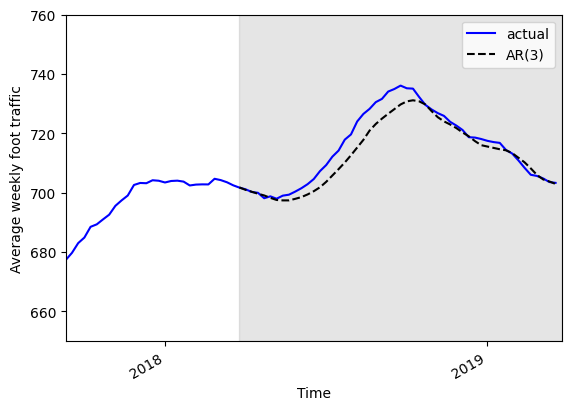

In [138]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'], 'b-', label = 'actual')
ax.plot(df['pred_foot_traffic'], 'k--', label = 'AR(3)')

plt.legend()
ax.set_xlim(920, 1000)
ax.set_ylim(650, 760)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
plt.xticks([936, 988], [2018, 2019])
fig.autofmt_xdate()
ax.axvspan(948, 1000, color = "#808080", alpha = 0.2)
plt.show()

이제 원본 데이터 집합의 평균절대오차를 측정하여 비즈니스적 의미를 파악해 보자.

In [141]:
from sklearn.metrics import mean_absolute_error
mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])
print(mae_AR_undiff)

2.868797296189548


즉, 한 주의 유동인구에 대한 예측이 실제값보다 평균적으로 2.86명 정도 높거나 낮게 차이를 보인다는 뜻이다.  